# Downstream Leased Assets Principal Component Analysis (PCA) and Hierarchical Clustering

In [11]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from sklearn.decomposition import PCA
import statsmodels.formula.api as smf
from sklearn.metrics import (r2_score, mean_squared_error, mean_squared_log_error, mean_absolute_error)
from sklearn.preprocessing import PowerTransformer
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering
from IPython.display import display

# Import downstream_leased_assets dataframe
downstream_leased_assets=pd.read_csv('downstream_leased_assets.csv')

In [2]:
downstream_leased_assets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1129 entries, 0 to 1128
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_name                1129 non-null   object 
 1   account_id                  1129 non-null   int64  
 2   Year                        1129 non-null   int64  
 3   incorporated_country        1129 non-null   object 
 4   Primary activity            1129 non-null   object 
 5   Primary sector              1129 non-null   object 
 6   Market_Cap_USD              1009 non-null   float64
 7   Third_party_verification    1129 non-null   object 
 8   Revenue_USD                 1024 non-null   float64
 9   ebitda_USD                  1024 non-null   float64
 10  grossProfit_USD             1024 non-null   float64
 11  netIncome_USD               1024 non-null   float64
 12  cashAndCashEquivalents_USD  1024 non-null   float64
 13  shortTermInvestments_USD    1024 

In [3]:
downstream_leased_assets.head()

,account_name,account_id,Year,incorporated_country,Primary activity,Primary sector,Market_Cap_USD,Third_party_verification,Revenue_USD,ebitda_USD,...,longTermInvestments_USD,totalAssets_USD,totalLiabilities_USD,totalInvestments_USD,totalDebt_USD,totalEquity_USD,Scope_3_emissions_type,Scope_3_emissions_amount,scope_1_2_emissions_amount,Year_sq
0,British Land Company,2297,2018,United Kingdom,REIT,Financial services,6.501391e+09,Third-party verification or assurance process ...,1.148080e+09,-3.022600e+08,...,3.597910e+09,1.556512e+10,4.530090e+09,3.402330e+09,3.966210e+09,1.103503e+10,Downstream leased assets,622285.0,14261.00,4072324
1,Britvic,2280,2018,United Kingdom,Non-alcoholic beverages,Food & beverage processing,2.702902e+09,Third-party verification or assurance process ...,1.909572e+09,2.719070e+08,...,5.118100e+07,2.235708e+09,1.756537e+09,9.728200e+07,9.767570e+08,4.791710e+08,Downstream leased assets,42095.0,45795.25,4072324
2,Capital & Counties Properties PLC,31426,2018,United Kingdom,Real estate owners & developers,Land & property ownership & development,NaN,Third-party verification or assurance process ...,1.017270e+08,-1.353820e+08,...,0.000000e+00,4.653407e+09,8.642350e+08,2.197100e+07,7.838440e+08,3.789172e+09,Downstream leased assets,640.0,1407.00,4072324
3,CNH Industrial NV,49607,2018,United Kingdom,"Agriculture, construction & mining machinery",Powered machinery,1.231232e+10,Third-party verification or assurance process ...,2.970600e+10,2.339000e+09,...,5.260000e+08,4.610000e+10,4.100200e+10,5.260000e+08,2.444500e+10,5.098000e+09,Downstream leased assets,116878.0,310663.50,4072324
4,Grainger plc,7677,2018,United Kingdom,Real estate owners & developers,Land & property ownership & development,1.459532e+09,No third-party verification or assurance,3.437890e+08,-2.413000e+06,...,2.948940e+08,2.400554e+09,1.364742e+09,2.948940e+08,1.220724e+09,1.035812e+09,Downstream leased assets,17311.0,805.75,4072324


In [4]:
# Rename features
downstream_leased_assets = downstream_leased_assets.rename(columns={'incorporated_country': 'Countries',
                                          'Primary activity': 'Primary_activity',
                                          'Primary sector': 'Primary_sector'})

# Drop unneeded columns
downstream_leased_assets = downstream_leased_assets.drop(
    ['Third_party_verification', 'Scope_3_emissions_type'], axis=1, errors='ignore')

downstream_leased_assets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1129 entries, 0 to 1128
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_name                1129 non-null   object 
 1   account_id                  1129 non-null   int64  
 2   Year                        1129 non-null   int64  
 3   Countries                   1129 non-null   object 
 4   Primary_activity            1129 non-null   object 
 5   Primary_sector              1129 non-null   object 
 6   Market_Cap_USD              1009 non-null   float64
 7   Revenue_USD                 1024 non-null   float64
 8   ebitda_USD                  1024 non-null   float64
 9   grossProfit_USD             1024 non-null   float64
 10  netIncome_USD               1024 non-null   float64
 11  cashAndCashEquivalents_USD  1024 non-null   float64
 12  shortTermInvestments_USD    1024 non-null   float64
 13  longTermInvestments_USD     1024 

In [5]:
# Looking at missing data
print(downstream_leased_assets.isnull().mean().sort_values(ascending=False).round(3) * 100)

Market_Cap_USD                10.6
cashAndCashEquivalents_USD     9.3
totalLiabilities_USD           9.3
totalEquity_USD                9.3
totalDebt_USD                  9.3
Revenue_USD                    9.3
ebitda_USD                     9.3
grossProfit_USD                9.3
netIncome_USD                  9.3
totalInvestments_USD           9.3
shortTermInvestments_USD       9.3
longTermInvestments_USD        9.3
totalAssets_USD                9.3
scope_1_2_emissions_amount     0.4
Scope_3_emissions_amount       0.0
account_name                   0.0
account_id                     0.0
Primary_sector                 0.0
Primary_activity               0.0
Countries                      0.0
Year                           0.0
Year_sq                        0.0
dtype: float64


## Downstream Leased Assets Principal Component Analysis

- Select numeric columns (excluding IDs, year, names, categories, raw emissions).
- Apply sign-log transform for normalization.
- Drop rows with missing values; track valid indices.
- Standardize features, fit PCA, and compute principal components.
- Append PCs (`PC1`, `PC2`, ..., `PCn`) to original DataFrame for valid rows.
- Plot scree and cumulative variance.
- Output: `downstream_leased_assets_with_pcs` with original data + PCs for modeling or analysis.

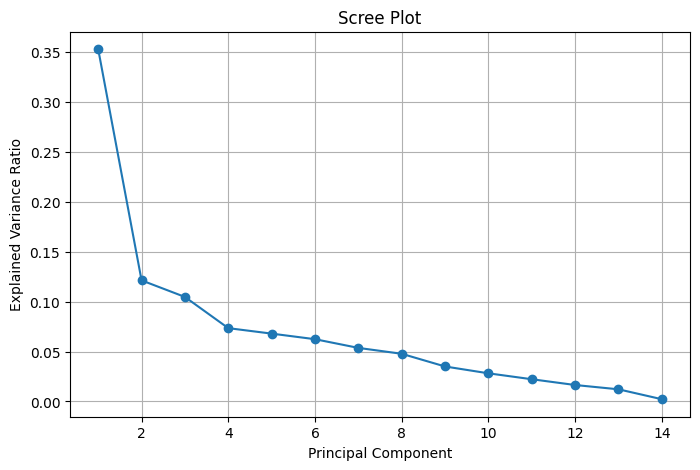

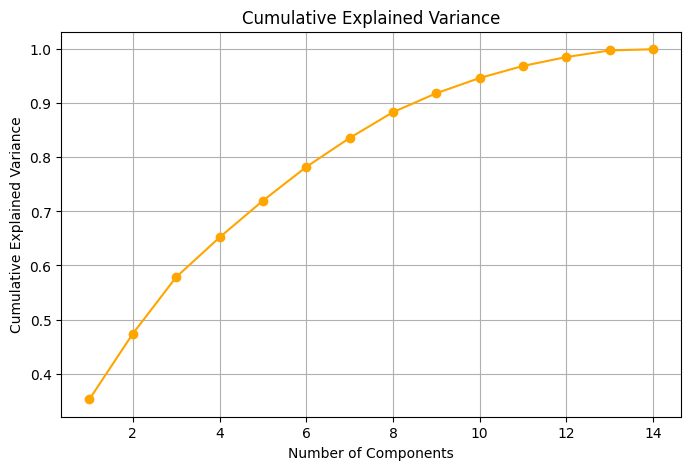

Cumulative variance explained by each additional principal component:
  PC1: 0.3526
  PC2: 0.4738
  PC3: 0.5785
  PC4: 0.6519
  PC5: 0.7198
  PC6: 0.7821
  PC7: 0.8358
  PC8: 0.8835
  PC9: 0.9186
  PC10: 0.9468
  PC11: 0.9690
  PC12: 0.9855
  PC13: 0.9977
  PC14: 1.0000


In [6]:
# --- STEP 1: Select appropriate columns for PCA ---
exclude_cols = [
    "account_id", "Year", "Year_sq",
    "account_name", "Countries", "Primary_activity", "Primary_sector"
]
numeric_cols = [
    col for col in downstream_leased_assets.columns
    if col not in exclude_cols and pd.api.types.is_numeric_dtype(downstream_leased_assets[col])
    and col != "Scope_3_emissions_amount"
]
X = downstream_leased_assets[numeric_cols].copy()

# --- STEP 2: Apply sign-log transformation ---
def sign_log_transform(x):
    return np.sign(x) * np.log1p(np.abs(x))
X_transformed = X.apply(sign_log_transform)

# --- STEP 3: Drop rows with missing values (keep track of indices) ---
X_dropped = X_transformed.dropna()
pca_indices = X_dropped.index

# --- STEP 4: Standardize the data ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dropped)

# --- STEP 5: Fit PCA ---
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# --- STEP 6: Create a DataFrame for PCs, index matches original ---
num_pcs = X_pca.shape[1]
pc_columns = [f"PC{i+1}" for i in range(num_pcs)]
pcs_df = pd.DataFrame(X_pca, columns=pc_columns, index=pca_indices)

# --- STEP 7: Append PCs back to the original DataFrame (only for valid rows) ---
downstream_leased_assets_with_pcs = downstream_leased_assets.copy()
for col in pc_columns:
    downstream_leased_assets_with_pcs[col] = np.nan  # initialize with NaN

downstream_leased_assets_with_pcs.loc[pcs_df.index, pc_columns] = pcs_df

# --- Plots ---
explained_var_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var_ratio) + 1), explained_var_ratio, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(explained_var_ratio) + 1),
    np.cumsum(explained_var_ratio),
    marker='o',
    color='orange'
)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# --- Print cumulative variance explained for each PC ---
cumulative_var = np.cumsum(explained_var_ratio)
print("Cumulative variance explained by each additional principal component:")
for i, var in enumerate(cumulative_var, start=1):
    print(f"  PC{i}: {var:.4f}")

# --- END ---
# downstream_leased_assets_with_pcs now contains the principal components for valid rows.

Nine pc's explains >90% of the variance in the data, seven pc's explain >80% of the variance and 4 pc's is at the bottom of the "elbow" with much less significant return for each increase in number of pc's.<br>
I'll investigate 9 pc's, 7 pc's and 4 pc's performance on HLM models.

## Downstream Leased Assets PCA Features (PC9, PC7 & PC4) + Train/Test Split

- Select numeric columns (excluding IDs, year, names, categories, raw emissions).
- Apply sign-log transform for normalization.
- Drop rows with missing values; keep account_id and Year for valid indices.
- Standardize features, fit PCA for 9 (`PC9_*`), 7 (`PC7_*`), and 4 (`PC4_*`) components.
- Append all principal components to the original DataFrame.
- Add signed log-transformed target variable.
- Optionally, rename columns for consistency.
- **Split data:**  
  - `train_df`: years 2018–2022  
  - `test_df`: year 2023  
  - Test set includes only companies present in training.

**Output:**  
`downstream_leased_assets_pca` has original data plus PC9, PC7, PC4 features and transformed target.  
`train_df`, `test_df` are ready for downstream modeling/evaluation.

In [8]:
# --- Prepare Data ---
exclude_cols = [
    "account_id", "Year", "Year_sq",
    "account_name", "Countries", "Primary_activity", "Primary_sector"
]
numeric_cols = [
    col for col in downstream_leased_assets.columns
    if col not in exclude_cols and pd.api.types.is_numeric_dtype(downstream_leased_assets[col])
    and col != "Scope_3_emissions_amount"
]
X = downstream_leased_assets[numeric_cols].copy()

def sign_log_transform(x):
    return np.sign(x) * np.log1p(np.abs(x))
X_transformed = X.apply(sign_log_transform)
pca_data = X_transformed.dropna().copy()
pca_data["account_id"] = downstream_leased_assets.loc[pca_data.index, "account_id"]
pca_data["Year"] = downstream_leased_assets.loc[pca_data.index, "Year"]

X_pca_input = pca_data.drop(columns=["account_id", "Year"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca_input)

# --- PCA for 9 components ---
pca9 = PCA(n_components=9)
pcs9 = pca9.fit_transform(X_scaled)
pcs9_df = pd.DataFrame(pcs9, columns=[f"PC9_{i+1}" for i in range(9)], index=pca_data.index)

# --- PCA for 7 components ---
pca7 = PCA(n_components=7)
pcs7 = pca7.fit_transform(X_scaled)
pcs7_df = pd.DataFrame(pcs7, columns=[f"PC7_{i+1}" for i in range(7)], index=pca_data.index)

# --- PCA for 4 components ---
pca4 = PCA(n_components=4)
pcs4 = pca4.fit_transform(X_scaled)
pcs4_df = pd.DataFrame(pcs4, columns=[f"PC4_{i+1}" for i in range(4)], index=pca_data.index)

# --- Merge all PC features to original DataFrame ---
downstream_leased_assets_pca = downstream_leased_assets.copy()
downstream_leased_assets_pca = downstream_leased_assets_pca.join(pcs9_df)
downstream_leased_assets_pca = downstream_leased_assets_pca.join(pcs7_df)
downstream_leased_assets_pca = downstream_leased_assets_pca.join(pcs4_df)

# --- Add transformed target and optionally other features ---
downstream_leased_assets_pca['slog_Scope_3_emissions_amount'] = sign_log_transform(downstream_leased_assets_pca['Scope_3_emissions_amount'])

# Optional: Rename columns for consistency
downstream_leased_assets_pca = downstream_leased_assets_pca.rename(columns={
    'incorporated_country': 'Countries',
    'Primary activity': 'Primary_activity',
    'Primary sector': 'Primary_sector'
})

# --- Split train/test by company and year ---
train_df = downstream_leased_assets_pca[downstream_leased_assets_pca['Year'].between(2018, 2022)].copy()
test_df  = downstream_leased_assets_pca[downstream_leased_assets_pca['Year'] == 2023].copy()

# Keep only companies present in training
valid_companies = set(train_df['account_id'].unique())
test_df = test_df[test_df['account_id'].isin(valid_companies)].copy()

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (879, 43)
Test shape: (211, 43)


In [9]:
print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 879 entries, 0 to 878
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_name                   879 non-null    object 
 1   account_id                     879 non-null    int64  
 2   Year                           879 non-null    int64  
 3   Countries                      879 non-null    object 
 4   Primary_activity               879 non-null    object 
 5   Primary_sector                 879 non-null    object 
 6   Market_Cap_USD                 781 non-null    float64
 7   Revenue_USD                    801 non-null    float64
 8   ebitda_USD                     801 non-null    float64
 9   grossProfit_USD                801 non-null    float64
 10  netIncome_USD                  801 non-null    float64
 11  cashAndCashEquivalents_USD     801 non-null    float64
 12  shortTermInvestments_USD       801 non-null    float64


## Downstream Leased Assets HLM (PC9) with Train/Test

- Uses `train_df` and `test_df` (already split and includes `slog_Scope_3_emissions_amount`).
- Filters for required features (`PC9_*`), target, and categorical columns.
- Ensures test set only includes categorical levels present in training.
- Fits hierarchical linear mixed-effects model with PC9 features, country, activity, and year.
- Evaluates and visualizes model performance on the test set.

**Output:**  
Performance metrics and visualizations for HLM using PC9 principal components.

                                                       Mixed Linear Model Regression Results
Model:                                     MixedLM                         Dependent Variable:                         slog_Scope_3_emissions_amount
No. Observations:                          777                             Method:                                     ML                           
No. Groups:                                229                             Scale:                                      0.6247                       
Min. group size:                           1                               Log-Likelihood:                             -1214.5641                   
Max. group size:                           5                               Converged:                                  Yes                          
Mean group size:                           3.4                                                                                                      
-------------

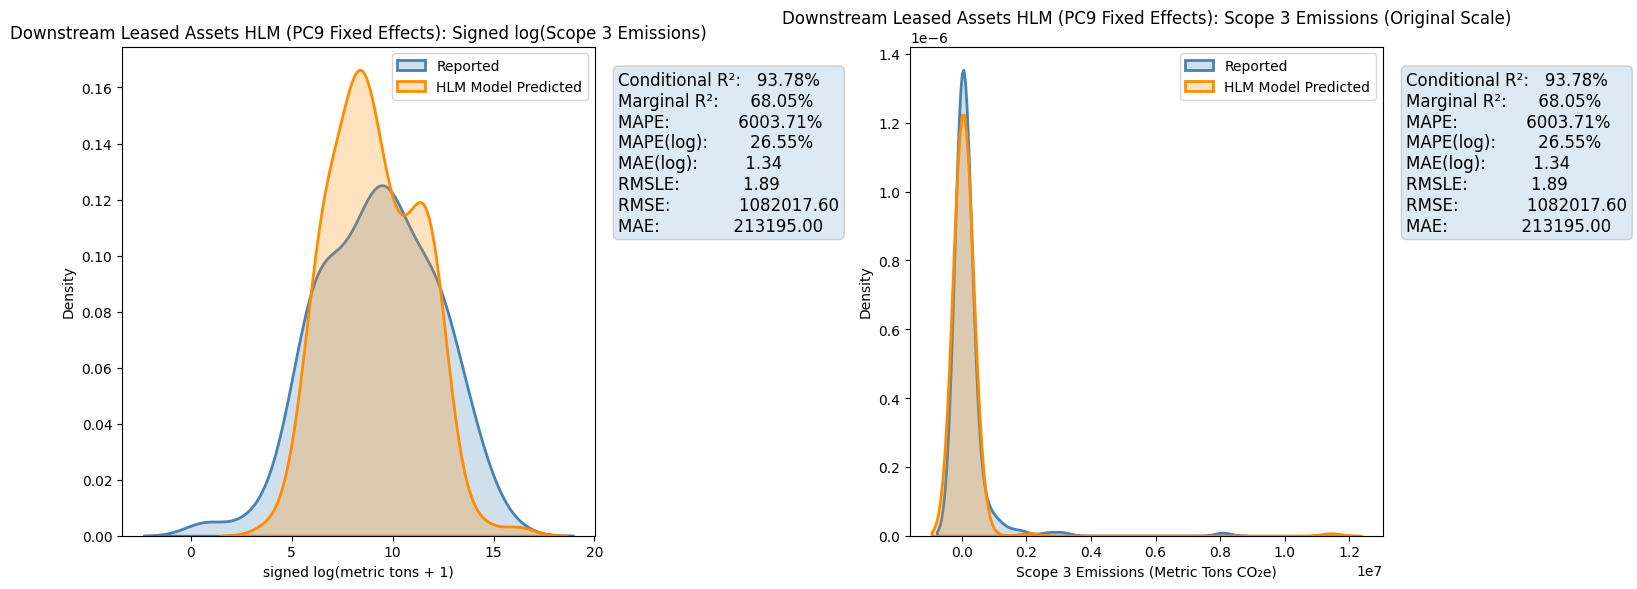

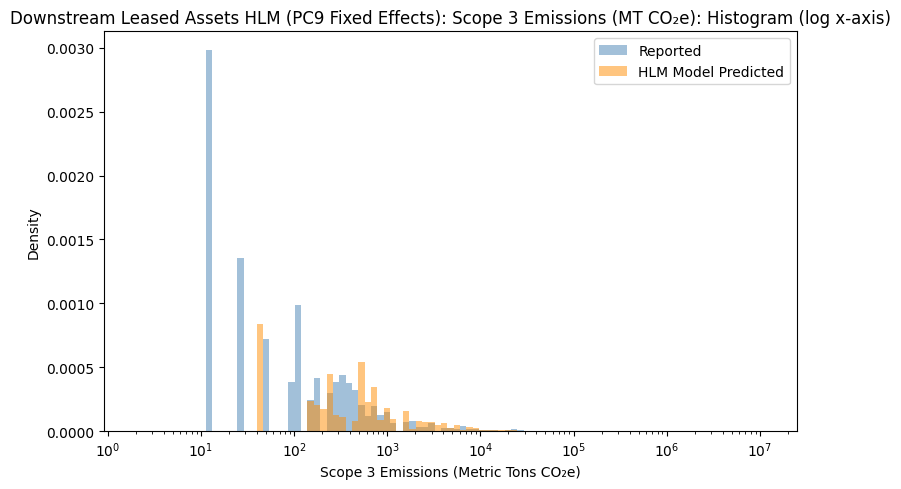

In [12]:
# --- Use train_df and test_df for HLM modeling ---

# Required columns
feature_cols_PC9 = [f'PC9_{i}' for i in range(1, 10)]  # PC9_1 to PC9_9
target_col_PC9 = 'slog_Scope_3_emissions_amount'
cat_cols_PC9 = ['Countries', 'Year', 'account_id', 'Primary_activity']

all_model_vars_PC9 = feature_cols_PC9 + [target_col_PC9] + cat_cols_PC9

# Filter for required columns only
train_df_PC9 = train_df.dropna(subset=all_model_vars_PC9).copy()
test_df_PC9  = test_df.dropna(subset=all_model_vars_PC9).copy()

# Ensure all categorical levels in test are present in train
for cat_col in ['Countries', 'Primary_activity']:
    train_cats = set(train_df_PC9[cat_col].unique())
    n_before = len(test_df_PC9)
    test_df_PC9 = test_df_PC9[test_df_PC9[cat_col].isin(train_cats)]
    n_after = len(test_df_PC9)
    if n_after < n_before:
        print(f"Warning: Dropped {n_before - n_after} test rows with unseen {cat_col} categories.")

if test_df_PC9.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # Model formula
    fixed_effects = (
        ' + '.join(feature_cols_PC9) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col_PC9} ~ {fixed_effects}'

    # Fit the mixed-effects model
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_PC9, groups=train_df_PC9['account_id'])
        mdf_PC9 = md.fit(reml=False)
    print(mdf_PC9.summary())

    # Calculate conditional and marginal R²
    var_fixed = np.var(mdf_PC9.fittedvalues)
    var_resid = mdf_PC9.scale
    var_random = mdf_PC9.cov_re.iloc[0, 0] if mdf_PC9.cov_re.shape[0] > 0 else 0.0
    var_random_total = var_random

    r2_marginal = var_fixed / (var_fixed + var_random_total + var_resid)
    r2_conditional = (var_fixed + var_random_total) / (var_fixed + var_random_total + var_resid)

    print(f"Marginal R² (fixed only):      {r2_marginal:.4f}")
    print(f"Conditional R² (fixed+random): {r2_conditional:.4f}")

    # Predict on test set
    test_df_PC9['predicted_log'] = mdf_PC9.predict(test_df_PC9)
    test_df_PC9['predicted'] = np.sign(test_df_PC9['predicted_log']) * (np.expm1(np.abs(test_df_PC9['predicted_log'])))

    # Metrics
    y_true_log = test_df_PC9[target_col_PC9]
    y_pred_log = test_df_PC9['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_PC9['predicted']

    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)

    metrics_text = (
        f"Conditional R²:   {r2_conditional*100:.2f}%\n"
        f"Marginal R²:      {r2_marginal*100:.2f}%\n"
        f"MAPE:             {mape_orig:.2f}%\n"
        f"MAPE(log):        {mape_log:.2f}%\n"
        f"MAE(log):         {mae_log:.2f}\n"
        f"RMSLE:            {rmsle:.2f}\n"
        f"RMSE:             {rmse_orig:.2f}\n"
        f"MAE:              {mae_orig:.2f}"
    )

    print("\nDownstream Leased Assets HLM with PC9 Fixed Effects: Test Set Performance Metrics:")
    print(metrics_text)

    # Feature coefficients
    coef_df = pd.DataFrame({
        'coef': mdf_PC9.params,
        'pvalue': mdf_PC9.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))
    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Downstream Leased Assets HLM (PC9 Fixed Effects): Signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Downstream Leased Assets HLM (PC9 Fixed Effects): Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    plt.tight_layout()
    plt.show()
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)
    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="HLM Model Predicted")
    plt.xscale("log")
    plt.title("Downstream Leased Assets HLM (PC9 Fixed Effects): Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # RETURN METRICS FOR SUMMARY TABLE
    PC9_model_metrics = {
        "Model": "HLM PC9",
        "Conditional_R2": r2_conditional,
        "Marginal_R2": r2_marginal,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "MAE_log": mae_log,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "# Obs (train)": len(train_df_PC9),
        "# Obs (test)": len(test_df_PC9),
        "# Obs (train/test)": f"{len(train_df_PC9)}/{len(test_df_PC9)}"
    }

## Downstream Leased Assets HLM (PC7) with Train/Test

- Uses `train_df` and `test_df` (split, includes `slog_Scope_3_emissions_amount`).
- Filters for required features (`PC7_*`), target, and categorical columns.
- Ensures test set only includes categorical levels present in training.
- Fits hierarchical linear mixed-effects model with PC7 features, country, activity, and year.
- Evaluates and visualizes model performance on the test set.

**Output:**  
Performance metrics and visualizations for HLM using PC7 principal components.

                                              Mixed Linear Model Regression Results
Model:                               MixedLM                   Dependent Variable:                   slog_Scope_3_emissions_amount
No. Observations:                    777                       Method:                               ML                           
No. Groups:                          229                       Scale:                                0.6461                       
Min. group size:                     1                         Log-Likelihood:                       -1216.3616                   
Max. group size:                     5                         Converged:                            Yes                          
Mean group size:                     3.4                                                                                          
----------------------------------------------------------------------------------------------------------------------------------

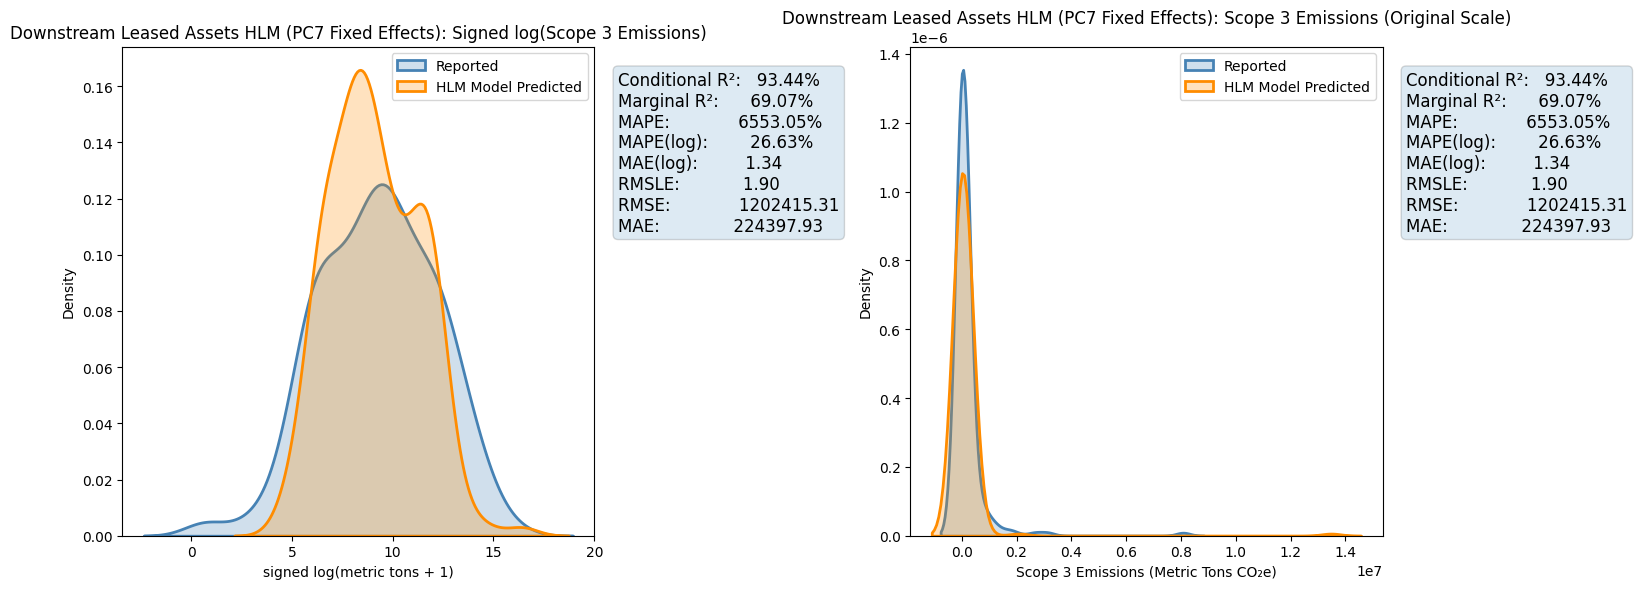

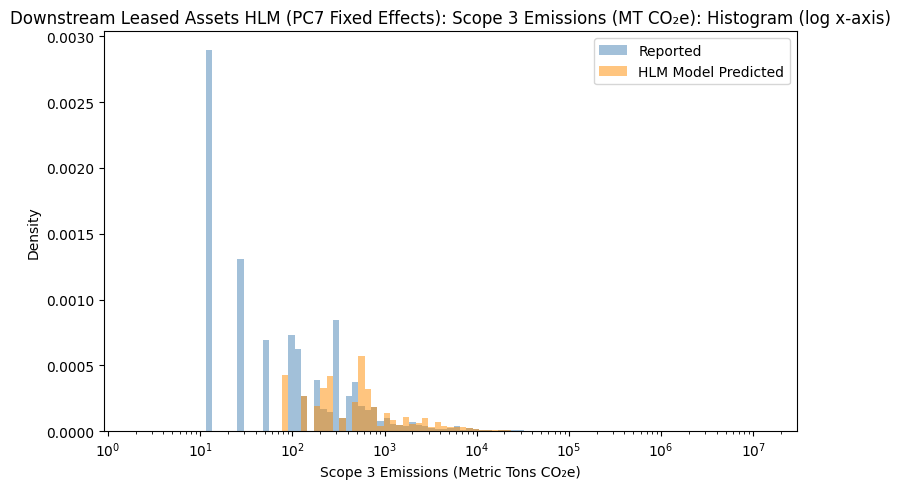

In [13]:
# --- Use train_df and test_df for HLM modeling with PC7 components ---

# Required columns
feature_cols_PC7 = [f'PC7_{i}' for i in range(1, 8)]  # PC7_1 to PC7_7
target_col_PC7 = 'slog_Scope_3_emissions_amount'
cat_cols_PC7 = ['Countries', 'Year', 'account_id', 'Primary_activity']

all_model_vars_PC7 = feature_cols_PC7 + [target_col_PC7] + cat_cols_PC7

# Filter for required columns only
train_df_PC7 = train_df.dropna(subset=all_model_vars_PC7).copy()
test_df_PC7  = test_df.dropna(subset=all_model_vars_PC7).copy()

# Ensure all categorical levels in test are present in train
for cat_col in ['Countries', 'Primary_activity']:
    train_cats = set(train_df_PC7[cat_col].unique())
    n_before = len(test_df_PC7)
    test_df_PC7 = test_df_PC7[test_df_PC7[cat_col].isin(train_cats)]
    n_after = len(test_df_PC7)
    if n_after < n_before:
        print(f"Warning: Dropped {n_before - n_after} test rows with unseen {cat_col} categories.")

if test_df_PC7.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # Model formula
    fixed_effects = (
        ' + '.join(feature_cols_PC7) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col_PC7} ~ {fixed_effects}'

    # Fit the mixed-effects model
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_PC7, groups=train_df_PC7['account_id'])
        mdf_PC7 = md.fit(reml=False)
    print(mdf_PC7.summary())

    # Calculate conditional and marginal R²
    var_fixed = np.var(mdf_PC7.fittedvalues)
    var_resid = mdf_PC7.scale
    var_random = mdf_PC7.cov_re.iloc[0, 0] if mdf_PC7.cov_re.shape[0] > 0 else 0.0
    var_random_total = var_random

    r2_marginal = var_fixed / (var_fixed + var_random_total + var_resid)
    r2_conditional = (var_fixed + var_random_total) / (var_fixed + var_random_total + var_resid)

    print(f"Marginal R² (fixed only):      {r2_marginal:.4f}")
    print(f"Conditional R² (fixed+random): {r2_conditional:.4f}")

    # Predict on test set
    test_df_PC7['predicted_log'] = mdf_PC7.predict(test_df_PC7)
    test_df_PC7['predicted'] = np.sign(test_df_PC7['predicted_log']) * (np.expm1(np.abs(test_df_PC7['predicted_log'])))

    # Metrics
    y_true_log = test_df_PC7[target_col_PC7]
    y_pred_log = test_df_PC7['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_PC7['predicted']

    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)

    metrics_text = (
        f"Conditional R²:   {r2_conditional*100:.2f}%\n"
        f"Marginal R²:      {r2_marginal*100:.2f}%\n"
        f"MAPE:             {mape_orig:.2f}%\n"
        f"MAPE(log):        {mape_log:.2f}%\n"
        f"MAE(log):         {mae_log:.2f}\n"
        f"RMSLE:            {rmsle:.2f}\n"
        f"RMSE:             {rmse_orig:.2f}\n"
        f"MAE:              {mae_orig:.2f}"
    )

    print("\nDownstream Leased Assets HLM with PC7 Fixed Effects: Test Set Performance Metrics:")
    print(metrics_text)

    # Feature coefficients
    coef_df = pd.DataFrame({
        'coef': mdf_PC7.params,
        'pvalue': mdf_PC7.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))
    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Downstream Leased Assets HLM (PC7 Fixed Effects): Signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Downstream Leased Assets HLM (PC7 Fixed Effects): Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    plt.tight_layout()
    plt.show()
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)
    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="HLM Model Predicted")
    plt.xscale("log")
    plt.title("Downstream Leased Assets HLM (PC7 Fixed Effects): Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # RETURN METRICS FOR SUMMARY TABLE
    PC7_model_metrics = {
        "Model": "HLM PC7",
        "Conditional_R2": r2_conditional,
        "Marginal_R2": r2_marginal,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "MAE_log": mae_log,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "# Obs (train)": len(train_df_PC7),
        "# Obs (test)": len(test_df_PC7),
        "# Obs (train/test)": f"{len(train_df_PC7)}/{len(test_df_PC7)}"
    }

## Downstream Leased Assets HLM (PC4) with Train/Test

- Uses `train_df` and `test_df` (split, includes `slog_Scope_3_emissions_amount`).
- Filters for required features (`PC4_*`), target, and categorical columns.
- Ensures test set only includes categorical levels present in training.
- Fits hierarchical linear mixed-effects model with PC4 features, country, activity, and year.
- Evaluates and visualizes model performance on the test set.

**Output:**  
Performance metrics and visualizations for HLM using PC4 principal components.

                                      Mixed Linear Model Regression Results
Model:                          MixedLM             Dependent Variable:             slog_Scope_3_emissions_amount
No. Observations:               777                 Method:                         ML                           
No. Groups:                     229                 Scale:                          0.6427                       
Min. group size:                1                   Log-Likelihood:                 -1222.1029                   
Max. group size:                5                   Converged:                      Yes                          
Mean group size:                3.4                                                                              
-----------------------------------------------------------------------------------------------------------------
                                                                     Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
------------

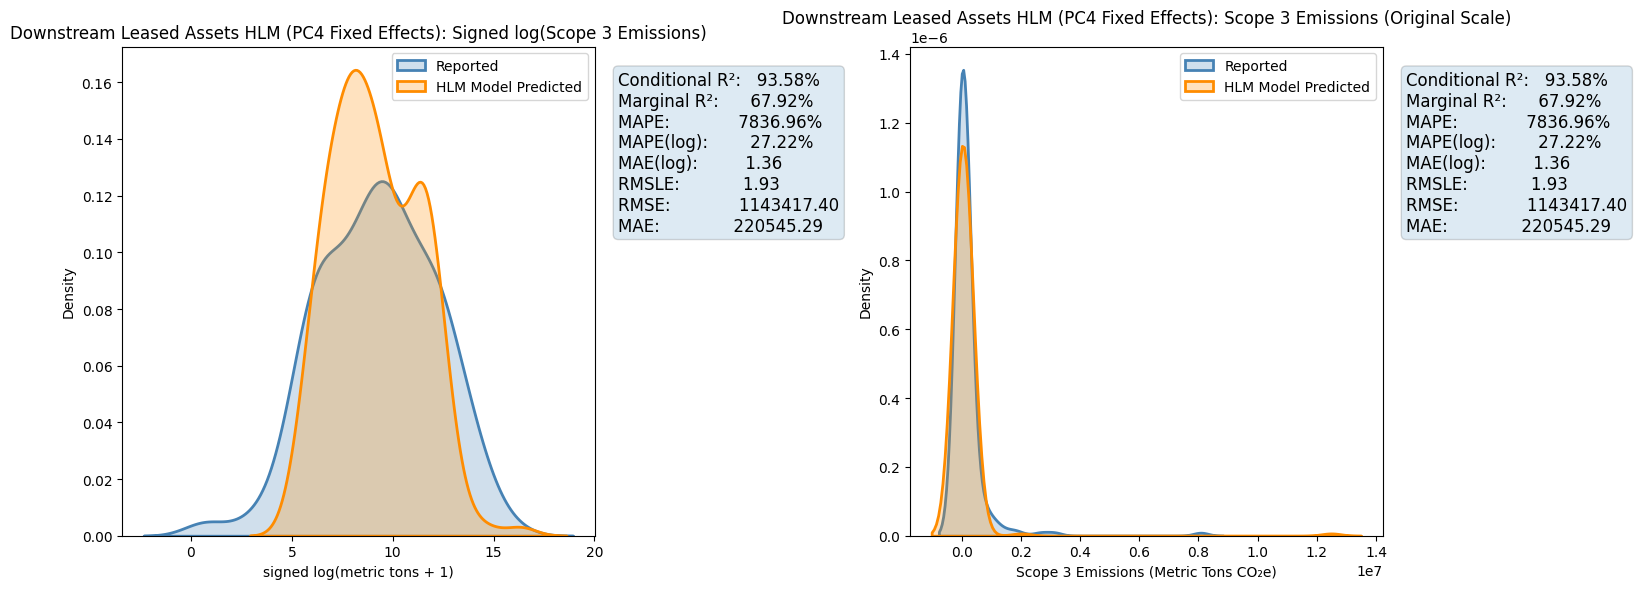

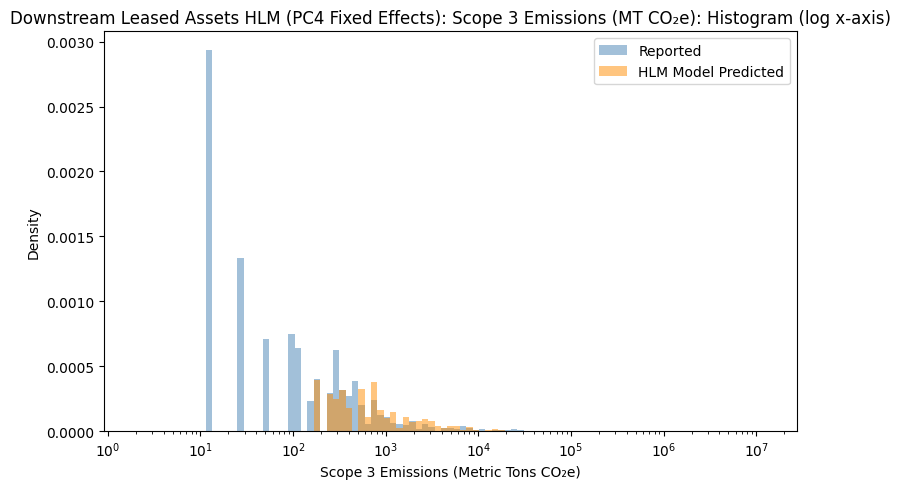

In [14]:
# --- Use train_df and test_df for HLM modeling with PC4 components ---

# Required columns
feature_cols_PC4 = [f'PC4_{i}' for i in range(1, 5)]  # PC4_1 to PC4_4
target_col_PC4 = 'slog_Scope_3_emissions_amount'
cat_cols_PC4 = ['Countries', 'Year', 'account_id', 'Primary_activity']

all_model_vars_PC4 = feature_cols_PC4 + [target_col_PC4] + cat_cols_PC4

# Filter for required columns only
train_df_PC4 = train_df.dropna(subset=all_model_vars_PC4).copy()
test_df_PC4  = test_df.dropna(subset=all_model_vars_PC4).copy()

# Ensure all categorical levels in test are present in train
for cat_col in ['Countries', 'Primary_activity']:
    train_cats = set(train_df_PC4[cat_col].unique())
    n_before = len(test_df_PC4)
    test_df_PC4 = test_df_PC4[test_df_PC4[cat_col].isin(train_cats)]
    n_after = len(test_df_PC4)
    if n_after < n_before:
        print(f"Warning: Dropped {n_before - n_after} test rows with unseen {cat_col} categories.")

if test_df_PC4.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # Model formula
    fixed_effects = (
        ' + '.join(feature_cols_PC4) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col_PC4} ~ {fixed_effects}'

    # Fit the mixed-effects model
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_PC4, groups=train_df_PC4['account_id'])
        mdf_PC4 = md.fit(reml=False)
    print(mdf_PC4.summary())

    # Calculate conditional and marginal R²
    var_fixed = np.var(mdf_PC4.fittedvalues)
    var_resid = mdf_PC4.scale
    var_random = mdf_PC4.cov_re.iloc[0, 0] if mdf_PC4.cov_re.shape[0] > 0 else 0.0
    var_random_total = var_random

    r2_marginal = var_fixed / (var_fixed + var_random_total + var_resid)
    r2_conditional = (var_fixed + var_random_total) / (var_fixed + var_random_total + var_resid)

    print(f"Marginal R² (fixed only):      {r2_marginal:.4f}")
    print(f"Conditional R² (fixed+random): {r2_conditional:.4f}")

    # Predict on test set
    test_df_PC4['predicted_log'] = mdf_PC4.predict(test_df_PC4)
    test_df_PC4['predicted'] = np.sign(test_df_PC4['predicted_log']) * (np.expm1(np.abs(test_df_PC4['predicted_log'])))

    # Metrics
    y_true_log = test_df_PC4[target_col_PC4]
    y_pred_log = test_df_PC4['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_PC4['predicted']

    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)

    metrics_text = (
        f"Conditional R²:   {r2_conditional*100:.2f}%\n"
        f"Marginal R²:      {r2_marginal*100:.2f}%\n"
        f"MAPE:             {mape_orig:.2f}%\n"
        f"MAPE(log):        {mape_log:.2f}%\n"
        f"MAE(log):         {mae_log:.2f}\n"
        f"RMSLE:            {rmsle:.2f}\n"
        f"RMSE:             {rmse_orig:.2f}\n"
        f"MAE:              {mae_orig:.2f}"
    )

    print("\nDownstream Leased Assets HLM with PC4 Fixed Effects: Test Set Performance Metrics:")
    print(metrics_text)

    # Feature coefficients
    coef_df = pd.DataFrame({
        'coef': mdf_PC4.params,
        'pvalue': mdf_PC4.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))
    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Downstream Leased Assets HLM (PC4 Fixed Effects): Signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Downstream Leased Assets HLM (PC4 Fixed Effects): Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    plt.tight_layout()
    plt.show()
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)
    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="HLM Model Predicted")
    plt.xscale("log")
    plt.title("Downstream Leased Assets HLM (PC4 Fixed Effects): Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # RETURN METRICS FOR SUMMARY TABLE
    PC4_model_metrics = {
        "Model": "HLM PC4",
        "Conditional_R2": r2_conditional,
        "Marginal_R2": r2_marginal,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "MAE_log": mae_log,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "# Obs (train)": len(train_df_PC4),
        "# Obs (test)": len(test_df_PC4),
        "# Obs (train/test)": f"{len(train_df_PC4)}/{len(test_df_PC4)}"
    }

Now I'll look into hierarchical clustering to determine if that may add value to increasing prediction accuracy.

## Hierarchical Clustering and Append Cluster Feature to Train/Test DataFrames

- Cluster observations using hierarchical clustering on standardized PC4 features.
- Find optimal cluster number via silhouette score.
- Assign cluster labels to observations and append as a 'Cluster' column in the full DataFrame.
- Add the 'Cluster' feature to both `train_df` and `test_df` for all valid rows.
- These sets are now ready for downstream modeling with the cluster feature included.

**Output:**  
`train_df` and `test_df` each include a 'Cluster' column for use in models or analysis.

Optimal number of clusters (highest silhouette score): 3


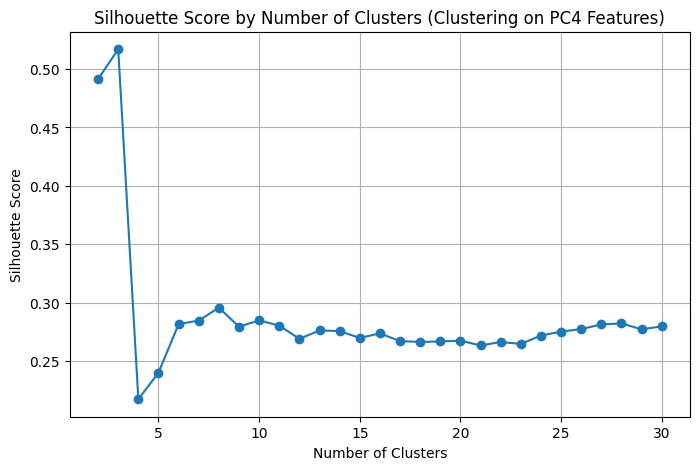

Number of observations in each cluster:
3    906
1     64
2     25
Name: count, dtype: int64


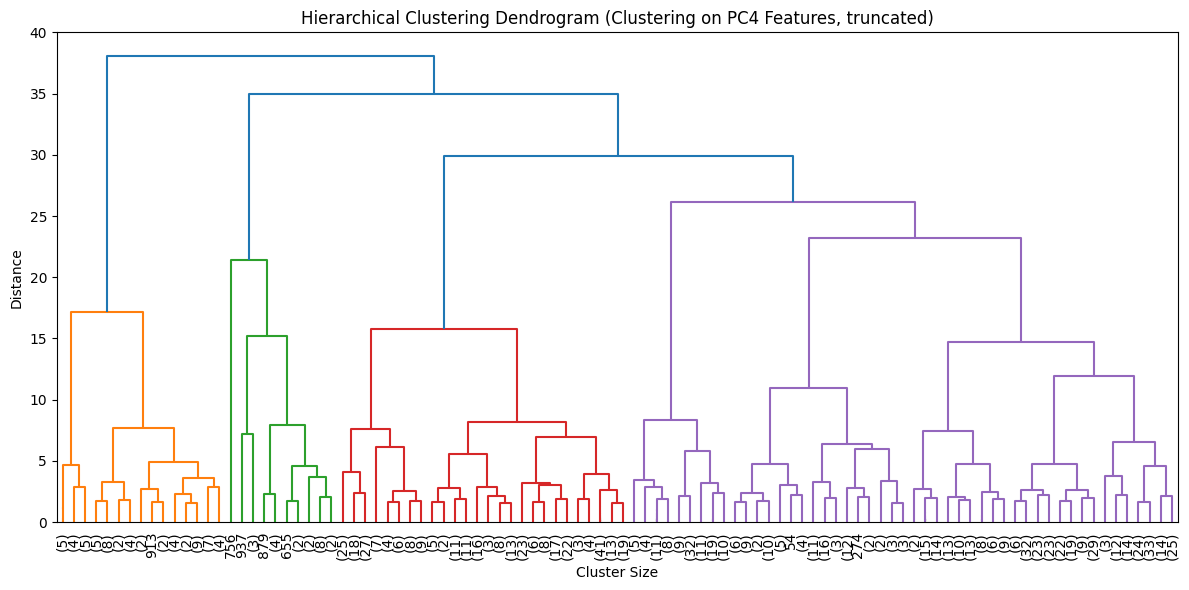

In [15]:
# --- STEP 1: Select PC4 PCA components for clustering ---
pc4_cols = [f'PC4_{i}' for i in range(1, 5)]
X_pc4 = downstream_leased_assets_pca[pc4_cols].dropna()
clust_indices = X_pc4.index

# --- STEP 2: Standardize the PC4 data ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pc4)

# --- STEP 3: Hierarchical clustering (Ward linkage) ---
Z = linkage(X_scaled, method='ward')

# --- STEP 4: Find optimal number of clusters using silhouette score ---
range_n_clusters = range(2, 31)  # 2 to 30 clusters
sil_scores = []

for n_clusters in range_n_clusters:
    labels = fcluster(Z, n_clusters, criterion='maxclust')
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

optimal_n_clusters = range_n_clusters[np.argmax(sil_scores)]
print(f"Optimal number of clusters (highest silhouette score): {optimal_n_clusters}")

# --- Plot silhouette scores ---
plt.figure(figsize=(8,5))
plt.plot(range_n_clusters, sil_scores, marker='o')
plt.title('Silhouette Score by Number of Clusters (Clustering on PC4 Features)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# --- STEP 5: Assign optimal cluster labels ---
labels_optimal = fcluster(Z, optimal_n_clusters, criterion='maxclust')

# --- STEP 6: Append cluster labels back to original DataFrame (only for valid rows) ---
downstream_leased_assets_pca_clusters = downstream_leased_assets_pca.copy()
downstream_leased_assets_pca_clusters['Cluster'] = np.nan  # initialize with NaN
downstream_leased_assets_pca_clusters.loc[clust_indices, 'Cluster'] = labels_optimal

# --- Print cluster counts ---
print("Number of observations in each cluster:")
print(pd.Series(labels_optimal).value_counts())

# --- Optionally plot dendrogram (subset for readability) ---
plt.figure(figsize=(12, 6))
sample_size = min(100, len(X_scaled))  # Plot up to 100 samples for clarity
dendrogram(Z, truncate_mode='lastp', p=sample_size, leaf_rotation=90, leaf_font_size=10, show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (Clustering on PC4 Features, truncated)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# --- STEP 7: Append Cluster feature to train and test sets ---
train_df['Cluster'] = downstream_leased_assets_pca_clusters.loc[train_df.index, 'Cluster']
test_df['Cluster'] = downstream_leased_assets_pca_clusters.loc[test_df.index, 'Cluster']

In [16]:
print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 879 entries, 0 to 878
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_name                   879 non-null    object 
 1   account_id                     879 non-null    int64  
 2   Year                           879 non-null    int64  
 3   Countries                      879 non-null    object 
 4   Primary_activity               879 non-null    object 
 5   Primary_sector                 879 non-null    object 
 6   Market_Cap_USD                 781 non-null    float64
 7   Revenue_USD                    801 non-null    float64
 8   ebitda_USD                     801 non-null    float64
 9   grossProfit_USD                801 non-null    float64
 10  netIncome_USD                  801 non-null    float64
 11  cashAndCashEquivalents_USD     801 non-null    float64
 12  shortTermInvestments_USD       801 non-null    float64


## Downstream Leased Assets HLM (PC4 + Cluster) with Train/Test

- Uses `train_df` and `test_df` (containing PC4 features, `Cluster` feature, and `slog_Scope_3_emissions_amount`).
- Filters for required features (`PC4_*`, `Cluster`), target, and categorical columns.
- Ensures test set only includes categorical levels present in training, including cluster labels.
- Fits hierarchical linear mixed-effects model with PC4 features, cluster, country, activity, and year.
- Evaluates and visualizes model performance on the test set.

**Output:**  
Performance metrics and visualizations for HLM using PC4 principal components and cluster membership.

                                     Mixed Linear Model Regression Results
Model:                         MixedLM             Dependent Variable:             slog_Scope_3_emissions_amount
No. Observations:              777                 Method:                         ML                           
No. Groups:                    229                 Scale:                          0.6046                       
Min. group size:               1                   Log-Likelihood:                 -1220.2073                   
Max. group size:               5                   Converged:                      Yes                          
Mean group size:               3.4                                                                              
----------------------------------------------------------------------------------------------------------------
                                                                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------

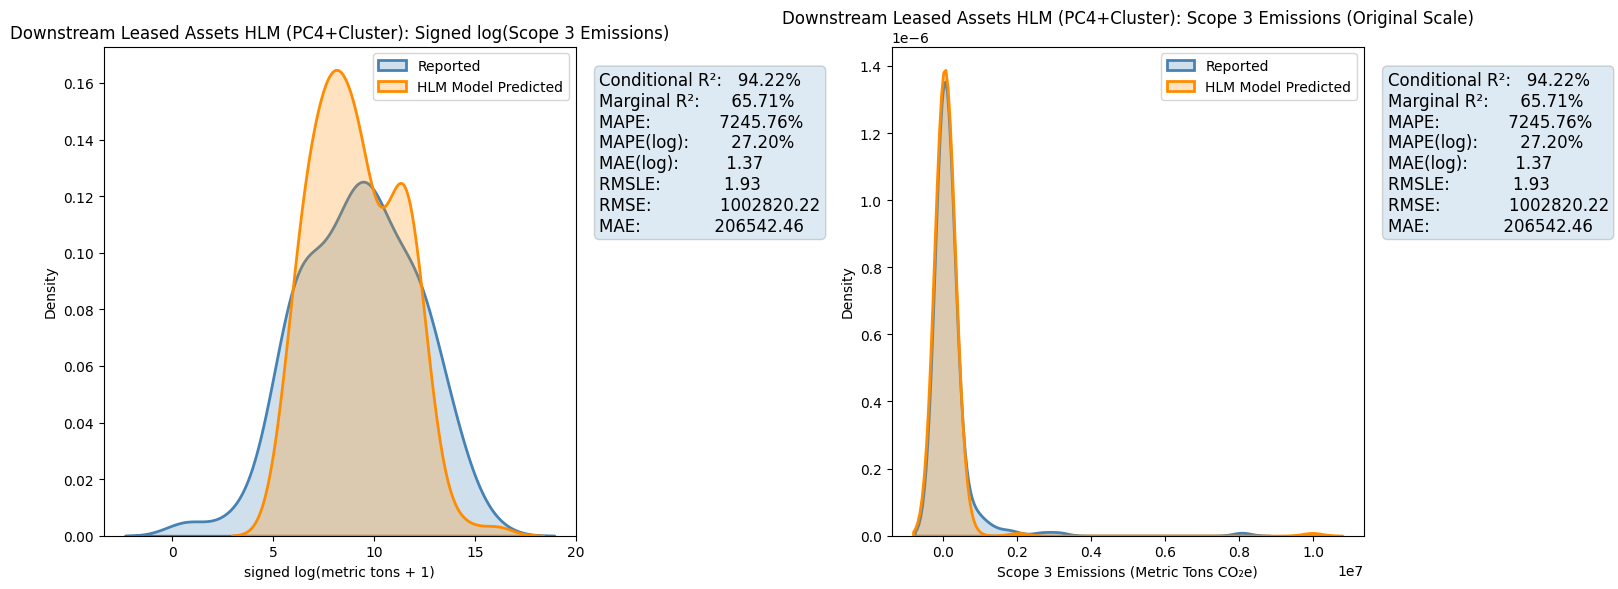

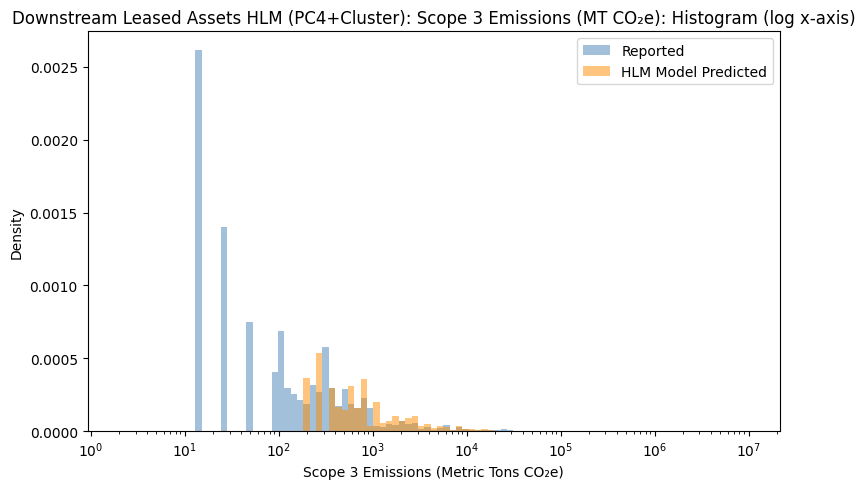

In [17]:
# --- PC4 + Cluster HLM using train_df and test_df with Cluster feature ---

feature_cols_pc4_cluster = [f'PC4_{i}' for i in range(1, 5)] + ['Cluster']
target_col = 'slog_Scope_3_emissions_amount'
cat_cols = ['Countries', 'Year', 'account_id', 'Primary_activity']

all_model_vars = feature_cols_pc4_cluster + [target_col] + cat_cols

# --- Prepare Data ---
# Use train_df and test_df that already contain the Cluster feature
train_df_pc4c = train_df.dropna(subset=all_model_vars).copy()
test_df_pc4c  = test_df.dropna(subset=all_model_vars).copy()

# --- Ensure all categorical levels in test are present in train ---
for cat_col in ['Countries', 'Primary_activity', 'Cluster']:
    train_cats = set(train_df_pc4c[cat_col].unique())
    n_before = len(test_df_pc4c)
    test_df_pc4c = test_df_pc4c[test_df_pc4c[cat_col].isin(train_cats)]
    n_after = len(test_df_pc4c)
    if n_after < n_before:
        print(f"Warning: Dropped {n_before - n_after} test rows with unseen {cat_col} categories.")

if test_df_pc4c.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- Model formula ---
    fixed_effects = (
        ' + '.join([f'C({col})' if col == 'Cluster' else col for col in feature_cols_pc4_cluster]) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col} ~ {fixed_effects}'

    # --- Fit the mixed-effects model ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_pc4c, groups=train_df_pc4c['account_id'])
        mdf_pc4c = md.fit(reml=False)
    print(mdf_pc4c.summary())

    # --- Calculate conditional and marginal R² ---
    var_fixed = np.var(mdf_pc4c.fittedvalues)
    var_resid = mdf_pc4c.scale
    var_random = mdf_pc4c.cov_re.iloc[0, 0] if mdf_pc4c.cov_re.shape[0] > 0 else 0.0
    var_random_total = var_random

    r2_marginal = var_fixed / (var_fixed + var_random_total + var_resid)
    r2_conditional = (var_fixed + var_random_total) / (var_fixed + var_random_total + var_resid)

    print(f"Marginal R² (fixed only):      {r2_marginal:.4f}")
    print(f"Conditional R² (fixed+random): {r2_conditional:.4f}")

    # --- Predict on test set ---
    test_df_pc4c['predicted_log'] = mdf_pc4c.predict(test_df_pc4c)
    test_df_pc4c['predicted'] = np.sign(test_df_pc4c['predicted_log']) * (np.expm1(np.abs(test_df_pc4c['predicted_log'])))

    # --- Metrics ---
    y_true_log = test_df_pc4c[target_col]
    y_pred_log = test_df_pc4c['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_pc4c['predicted']

    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)

    metrics_text = (
        f"Conditional R²:   {r2_conditional*100:.2f}%\n"
        f"Marginal R²:      {r2_marginal*100:.2f}%\n"
        f"MAPE:             {mape_orig:.2f}%\n"
        f"MAPE(log):        {mape_log:.2f}%\n"
        f"MAE(log):         {mae_log:.2f}\n"
        f"RMSLE:            {rmsle:.2f}\n"
        f"RMSE:             {rmse_orig:.2f}\n"
        f"MAE:              {mae_orig:.2f}"
    )

    print("\nDownstream Leased Assets HLM with PC4+Cluster Fixed Effects: Test Set Performance Metrics:")
    print(metrics_text)

    # --- Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf_pc4c.params,
        'pvalue': mdf_pc4c.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))
    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    # --- Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Downstream Leased Assets HLM (PC4+Cluster): Signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Downstream Leased Assets HLM (PC4+Cluster): Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    plt.tight_layout()
    plt.show()
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)
    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="HLM Model Predicted")
    plt.xscale("log")
    plt.title("Downstream Leased Assets HLM (PC4+Cluster): Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- RETURN METRICS FOR SUMMARY TABLE ---
    pc4_cluster_model_metrics = {
        "Model": "HLM PC4+Cluster",
        "Conditional_R2": r2_conditional,
        "Marginal_R2": r2_marginal,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "MAE_log": mae_log,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "# Obs (train)": len(train_df_pc4c),
        "# Obs (test)": len(test_df_pc4c),
        "# Obs (train/test)": f"{len(train_df_pc4c)}/{len(test_df_pc4c)}"
    }

## Metrics Table

In [18]:
# --- Dynamically collect available model metrics ---
model_metric_names = [
    ("PC9_model_metrics",         "train_df_PC9",     "test_df_PC9",     "mdf_PC9",     "pca9"),
    ("PC7_model_metrics",         "train_df_PC7",     "test_df_PC7",     "mdf_PC7",     "pca7"),
    ("PC4_model_metrics",         "train_df_PC4",     "test_df_PC4",     "mdf_PC4",     "pca4"),
    ("pc4_cluster_model_metrics", "train_df_pc4c",    "test_df_pc4c",    "mdf_pc4c",    "pca4"),
]

metrics_dicts = []
trains = []
tests = []
fits = []
explained_vars = []

for metric_name, train_name, test_name, fit_name, pca_name in model_metric_names:
    if (metric_name in globals() and
        train_name in globals() and
        test_name in globals() and
        fit_name in globals() and
        pca_name in globals()):
        metrics_dicts.append(globals()[metric_name])
        trains.append(globals()[train_name])
        tests.append(globals()[test_name])
        fits.append(globals()[fit_name])
        explained_vars.append(sum(getattr(globals()[pca_name], "explained_variance_ratio_", [np.nan])))

# --- Attach observation counts, convergence status, and explained variance to each dictionary ---
for metrics, train, test, fit_result, explained_var in zip(
        metrics_dicts, trains, tests, fits, explained_vars):
    metrics["# Obs (train)"] = len(train)
    metrics["# Obs (test)"] = len(test)
    metrics["# Obs (train/test)"] = f"{len(train)}/{len(test)}"
    metrics["Converged"] = "Yes" if getattr(fit_result, "converged", False) else "No"
    metrics["PC Explained Variance"] = explained_var

# --- Add a new row for your "Optimized" model ---
optimized_row = {
    "Model": "Optimized Downstream Leased Assets HLM",
    "Conditional_R2": 0.9258,   # as a fraction, not percent
    "Marginal_R2": 0.6991,
    "RMSE": 738797.07,
    "MAE": 160380.8,
    "MAE_log": 1.34,
    "RMSLE": 1.92,
    "MAPE": 9200.7,
    "# Obs (train/test)": "749/159",
    "PC Explained Variance": np.nan,
    "Converged": "Yes"
}
metrics_dicts.append(optimized_row)

metrics_df = pd.DataFrame(metrics_dicts)

# --- Order columns for summary ---
desired_order = [
    "Model", "PC Explained Variance", "Conditional_R2", "Marginal_R2",
    "RMSE", "MAE", "MAE_log", "RMSLE", "MAPE", "# Obs (train/test)", "Converged"
]

if "MAE_log" not in metrics_df.columns:
    metrics_df["MAE_log"] = np.nan

metrics_df = metrics_df[[col for col in desired_order if col in metrics_df.columns]]

# --- Format for display ---
metrics_df_display = metrics_df.copy()
if "Conditional_R2" in metrics_df_display.columns:
    metrics_df_display["Conditional_R2"] = (metrics_df_display["Conditional_R2"].astype(float) * 100).map("{:.2f}%".format)
if "Marginal_R2" in metrics_df_display.columns:
    metrics_df_display["Marginal_R2"] = (metrics_df_display["Marginal_R2"].astype(float) * 100).map("{:.2f}%".format)
for col in ["RMSE", "MAE", "MAE_log", "RMSLE", "MAPE", "PC Explained Variance"]:
    if col in metrics_df_display.columns:
        if col == "PC Explained Variance":
            metrics_df_display[col] = metrics_df_display[col].apply(lambda v: "{:.2%}".format(v) if pd.notnull(v) else "")
        else:
            metrics_df_display[col] = metrics_df_display[col].astype(float).map("{:.2f}".format)

# --- Display in notebook or print ---
try:
    display(metrics_df_display)
except Exception:
    print(metrics_df_display.to_string(index=False))

,Model,PC Explained Variance,Conditional_R2,Marginal_R2,RMSE,MAE,MAE_log,RMSLE,MAPE,# Obs (train/test),Converged
0,HLM PC9,91.86%,93.78%,68.05%,1082017.60,213195.00,1.34,1.89,6003.71,777/177,Yes
1,HLM PC7,83.58%,93.44%,69.07%,1202415.31,224397.93,1.34,1.90,6553.05,777/177,Yes
2,HLM PC4,65.19%,93.58%,67.92%,1143417.40,220545.29,1.36,1.93,7836.96,777/177,Yes
3,HLM PC4+Cluster,65.19%,94.22%,65.71%,1002820.22,206542.46,1.37,1.93,7245.76,777/177,Yes
4,Optimized Downstream Leased Assets HLM,,92.58%,69.91%,738797.07,160380.80,1.34,1.92,9200.70,749/159,Yes
